## Import libraries

In [203]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

## MNIST Dataset

In [204]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [205]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

## Hyperparameters

In [206]:
BATCH_SIZE = 256
EPOCHS = 5000
NOISE_DIM = 100
TRAIN_RATIO = 5
INTERVAL = 200

## Models

### Generator

In [207]:
def make_generator_model():
    model = tf.keras.Sequential()

    ## Layers
    model.add(layers.Dense(7*7*256, use_bias=False, input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    ## Inputs
    noise = tf.keras.Input(shape=(NOISE_DIM,))
    label = tf.keras.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Flatten()(layers.Embedding(10, 100)(label))

    ## Concatenate noise and label
    model_input = layers.multiply([noise, label_embedding])

    ## Output
    image = model(model_input)

    return tf.keras.Model([noise, label], image)

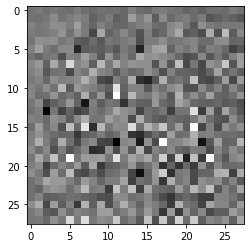

In [208]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
label = tf.random.uniform([1], minval=0, maxval=9, dtype=tf.int32)
generated_image = generator([noise, label], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [209]:
generator.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 1, 100)       1000        ['input_70[0][0]']               
                                                                                                  
 input_69 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 flatten_46 (Flatten)           (None, 100)          0           ['embedding_24[0][0]']           
                                                                                           

### Discriminator

In [210]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    ##Layers
    model.add(layers.Reshape((28, 28, 1), input_shape=(784,)))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    ## Inputs
    image = tf.keras.Input(shape=(28,28,1))
    flat_img = layers.Flatten()(image)

    label = tf.keras.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Flatten()(layers.Embedding(10, 784)(label))

    model_input = layers.multiply([flat_img, label_embedding])

    ## Output
    validity = model(model_input)

    return tf.keras.Model([image,label], validity)

In [211]:
discriminator = make_discriminator_model()
decision = discriminator([generated_image, label])
print (decision)

tf.Tensor([[0.49999976]], shape=(1, 1), dtype=float32)


In [212]:
discriminator.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 1, 784)       7840        ['input_72[0][0]']               
                                                                                                  
 flatten_48 (Flatten)           (None, 784)          0           ['input_71[0][0]']               
                                                                                           

## Utility

In [213]:
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("samples/%d.png" % epoch)
    plt.close()

In [214]:
def train_ratio(epoch):
    if epoch < 1500:
        return TRAIN_RATIO
    else:
        return max(1,TRAIN_RATIO *(0.5)**((epoch-1500)//100))

## Loss Functions and Optimizers

In [215]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_object = tf.keras.losses.BinaryCrossentropy()

In [216]:
## Discriminator setup
discriminator.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])
discriminator.trainable = False

In [217]:
## Generator setup
noise = layers.Input(shape=(NOISE_DIM,))
label = layers.Input(shape=(1,), dtype='int32')
image = generator([noise, label])

## Combined model
validity = discriminator([image, label])
combined = tf.keras.Model([noise, label], validity)
combined.compile(optimizer=optimizer, loss=loss_object)

## Training the model

In [218]:
real = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

discriminator_loss = []
generator_loss = []

In [219]:
for epoch in range(EPOCHS):
    print(f"----------- Epoch {epoch+1} -----------")

    idx = np.random.randint(0, train_images.shape[0], BATCH_SIZE)
    imgs, labels = train_images[idx], train_labels[idx]

    noise = np.random.normal(0, 1, (BATCH_SIZE, 100))

    if(epoch % train_ratio(epoch+1) == 0):
        discriminator.trainable = True
    
    gen_imgs = generator.predict([noise, labels])

    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    discriminator_loss.append(d_loss[0])

    discriminator.trainable = False

    g_loss = combined.train_on_batch([noise, labels], real)

    generator_loss.append(g_loss)

    print(f"Discriminator loss: {d_loss[0]}   Accuracy: {d_loss[1]}")
    print(f"Generator loss: {g_loss}")
    print('---------------------------------------')

    if((epoch+1) % INTERVAL==0):
        sample_images(epoch+1)



----------- Epoch 1 -----------
8/8 [==============================] - 1s 27ms/step
Discriminator loss: 0.693110466003418   Accuracy: 0.341796875
Generator loss: 0.6917192339897156
---------------------------------------
----------- Epoch 2 -----------
8/8 [==============================] - 0s 10ms/step
Discriminator loss: 0.6917901635169983   Accuracy: 0.486328125
Generator loss: 0.6908782720565796
---------------------------------------
----------- Epoch 3 -----------
8/8 [==============================] - 0s 10ms/step
Discriminator loss: 0.6907274425029755   Accuracy: 0.5
Generator loss: 0.690388560295105
---------------------------------------
----------- Epoch 4 -----------
8/8 [==============================] - 0s 10ms/step
Discriminator loss: 0.6898153722286224   Accuracy: 0.5
Generator loss: 0.6897260546684265
---------------------------------------
----------- Epoch 5 -----------
8/8 [==============================] - 0s 9ms/step
Discriminator loss: 0.6889367997646332   Accura